In [2]:
# SPA vs COIN_FF vs COIN_FF_RL (imitation of COIN_FF)

import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import animation
from shapely.geometry import LineString, MultiLineString
import networkx as nx
import heapq

## 1. Load shapefile and build TrafficNetwork

In [3]:
# Path to your shapefile
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"
gdf = gpd.read_file(path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

# If CRS is geographic (lat/lon), reproject to EPSG:2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
print("Reprojected CRS: ", gdf.crs)

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']
Reprojected CRS:  EPSG:2263


## 2. Core types

In [5]:
Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge
EdgeFlows = Dict[EdgeId, float]


@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float       # meters
    v_free: float         # free-flow speed (m/s)
    capacity: float       # max cars that fit on this segment
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    @property
    def free_time(self) -> float:
        """Free-flow travel time (seconds)."""
        return self.length_m / self.v_free

    def travel_time(self, flow: float) -> float:
        """BPR-style congestion travel time (seconds)."""
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    """Rounding keeps nodes consistent instead of tiny float differences."""
    return round(x, ndigits), round(y, ndigits)


## 3. Stochastic edge parameters

## Constants

In [6]:
# --- Capacity tuning constants (put near top of file) ---
# Default lanes by OSM 'highway' tag (very rough)
HIGHWAY_DEFAULT_LANES = {
    "motorway": 6,
    "trunk": 5,
    "primary": 5,
    "secondary": 4,
    "tertiary": 2,
    "residential": 2,
    "service": 2,
}

REF_SPEED = 13.89           # m/s ≈ 50 km/h
SPEED_CAPACITY_GAMMA = 0.2  # how strongly speed affects capacity

# Put these near the top of the file, next to your other globals
CAPACITY_SCALE = 20.0    # global multiplier for capacities
MIN_CAPACITY   = 500.0   # minimum cars per directed edge (model units)



In [7]:
def sample_car_length() -> float:
    # lognormal with median around 4.5m
    mu = math.log(4.5)
    sigma = 0.15
    length = random.lognormvariate(mu, sigma)
    return max(length, 3.5)  # clamp to > 3.5m


def sample_gap() -> float:
    # lognormal with median around 1.5m
    mu = math.log(1.5)
    sigma = 0.25
    gap = random.lognormvariate(mu, sigma)
    return max(gap, 0.5)


def sample_spacing() -> float:
    """Space per vehicle = car length + gap."""
    return sample_car_length() + sample_gap()


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    This gives a fatter tail toward low speeds.
    """
    median_s_per_m = 0.09  # ~40 km/h
    mu = math.log(median_s_per_m)
    sigma = 0.3  # spread; larger => more slow edges
    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m  # m/s

    # clamp speeds to a plausible urban range ~ 18–90 km/h
    v_free = max(min(v_free, 25.0), 5.0)
    return v_free

def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> TrafficNetwork:
    """
    Build a directed TrafficNetwork from a GeoDataFrame of street segments.

    Capacity is based on:
        - geometric length / spacing  (cars that fit on the segment)
        - free-flow speed (faster links get slightly higher capacity)
        - a global CAPACITY_SCALE (so capacities are large vs. agent flows)
        - a global MIN_CAPACITY (so no edge is absurdly small)

    The result is that, for your Manhattan test with ~100 agents,
    typical v/c ratios stay in a reasonable range instead of exploding.
    """
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for _, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                # --- stochastic spacing & free-flow speed ---
                spacing = sample_spacing()                # [m / car]
                v_free  = sample_free_speed_time_based()  # [m / s]

                # cars that physically fit on this small segment
                base_cars = max(length_m / spacing, 1.0)

                # modest boost for faster links (e.g. avenues vs local streets)
                v_ref = 15.0  # m/s ≈ 54 km/h
                speed_factor = max(v_free / v_ref, 0.5)   # avoid tiny factors

                # final capacity for this directed edge
                capacity = base_cars * speed_factor * CAPACITY_SCALE
                capacity = max(capacity, MIN_CAPACITY)

                # directed u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(
                        start=u,
                        end=v,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[u].append(e1)

                # bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(
                        start=v,
                        end=u,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)


# Build network
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")


# nodes: 37086
# edges: 81228


## 4. NetworkX conversion (for sanity plot)

# NX nodes: 37086 # NX edges: 81228


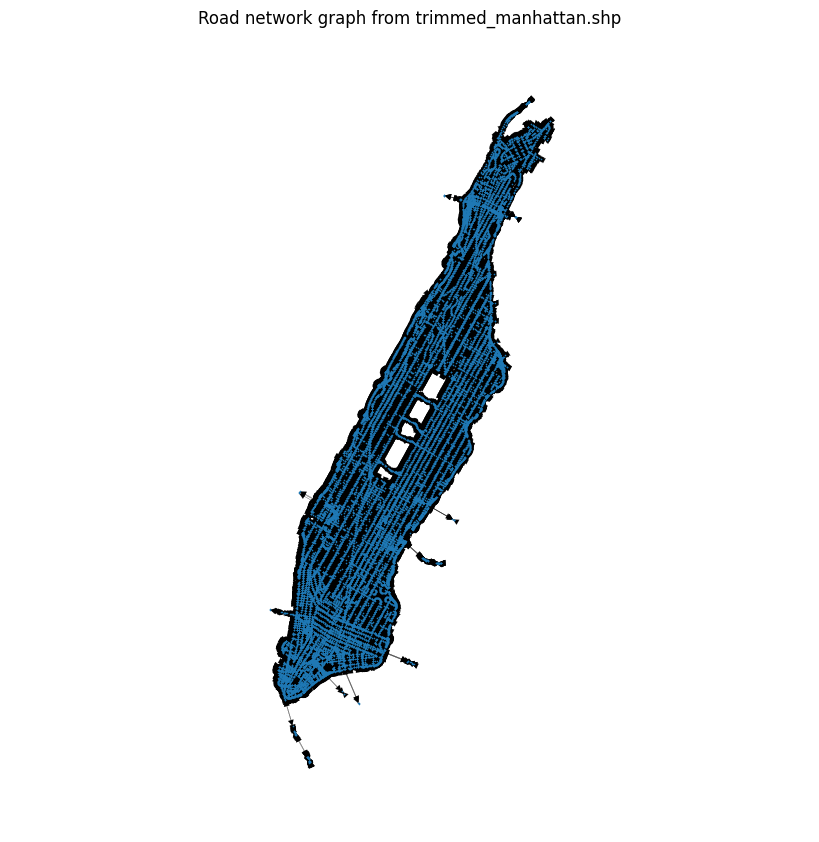

In [8]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G


G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

## 5. Agents + OD selection

In [9]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None


def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def sample_agents_north_south(
    network: TrafficNetwork,
    num_agents: int,
    band_split: float = 0.5,
) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]
    assert north_nodes and south_nodes, "North/south bands empty – check CRS/band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    """Pick a single north–south OD pair to keep SPA / COIN_FF comparable."""
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = top 20%, south = bottom 20%
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d


def sample_agents_fixed(
    network: TrafficNetwork,
    num_agents: int,
    origin: Node,
    destination: Node
) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]


## 6. Dijkstra (SPA) and marginal-cost Dijkstra (COIN_FF)

In [11]:
def dijkstra(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """Standard Dijkstra where cost = current travel time t(flow)."""
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])
            nd = d_u + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in total system travel time G
    if we send one more car along it?
    """
    f1 = flow_before
    f2 = flow_before + 1
    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)
    G1 = f1 * t1
    G2 = f2 * t2
    return G2 - G1


def dijkstra_coin_ff_marginal(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """
    Ford–Fulkerson style path search:
    shortest path where edge weight is the *marginal increase in G*
    if we send one additional car along that edge.
    Edges with flow >= capacity are treated as 'blocked'.
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            # Respect capacity (no residual capacity => no edge)
            if edge_flows[edge_id] >= edge.capacity:
                continue

            f_before = edge_flows[edge_id]
            marginal = edge_marginal_cost(edge, f_before)
            new_cost = cost_u + marginal

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []  # no path

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))



## 7. Routing: SPA and COIN_FF

In [12]:
def spa_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """Selfish Path Assignment (SPA): each agent uses shortest travel-time path."""
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent
    return agents, edge_flows


def coin_ff_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """
    Ford–Fulkerson–style COIN:
    - For each agent, find a path that minimizes the marginal increase in G
      (using dijkstra_coin_ff_marginal).
    - Push 1 unit of flow along that path.
    """
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra_coin_ff_marginal(
            network,
            agent.origin,
            agent.destination,
            edge_flows
        )
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0
    return agents, edge_flows


## 8. World utility & OD used for fixed experiments

In [13]:
def total_system_travel_time(network: TrafficNetwork, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total


# Fixed OD pair (global, to keep things simple and consistent)
origin, destination = pick_north_south_pair(manhattan_network)
zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))


def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

Origin: (1003758.659, 247447.157)
Destination: (980286.422, 196592.78)
Shortest path length (edges): 988


## 9. COIN_FF → Expert Dataset for Imitation Learning

In [14]:
def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]


def choose_action_eps_greedy(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    state_node: Node,
    dest_node: Node,
    epsilon: float
) -> Node:
    neighbors = get_neighbors(network, state_node)
    if not neighbors:
        return state_node  # dead end, stay put (loop will break)

    # exploration
    if random.random() < epsilon:
        return random.choice(neighbors)

    # exploitation: pick neighbor with highest Q
    best_q = None
    best_actions = []
    for a in neighbors:
        key = (state_node, dest_node, a)
        q = Q.get(key, 0.0)
        if best_q is None or q > best_q:
            best_q = q
            best_actions = [a]
        elif q == best_q:
            best_actions.append(a)
    return random.choice(best_actions)


def build_coin_ff_expert_dataset(
    network: TrafficNetwork,
    num_agents: int = 200,
    od_mode: str = "fixed"
):
    """
    Run COIN_FF once and record (state, dest, action) triples from the routes.
    We ONLY keep steps from agents that actually reach their destination.
    Returns:
        expert_triples, agents_coin_ff, flows_coin_ff
    """
    # Sample agents according to od_mode
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    # Route with COIN_FF
    agents_coin_ff, flows_coin_ff = coin_ff_route_all(network, agents)

    expert_triples = []  # list of (state_node, dest_node, action_node)
    for agent in agents_coin_ff:
        if not agent.path or agent.path[-1] != agent.destination:
            continue  # only successful trajectories
        d = agent.destination
        for (s, a) in edges_from_path(agent.path):
            expert_triples.append((s, d, a))

    print(
        f"Collected {len(expert_triples)} expert (s,d,a) triples "
        f"from {len(agents_coin_ff)} COIN_FF agents."
    )
    return expert_triples, agents_coin_ff, flows_coin_ff


def train_q_from_coin_ff_expert(
    expert_triples,
    alpha_bc: float = 0.5
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    Simple behavior-cloning style 'Q':
    For each expert (s, d, a) triple we push Q(s,d,a) toward 1.0.
    Later, route_with_trained_Q will act greedily wrt Q and
    (ideally) reproduce COIN_FF decisions.
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}
    for (s, d, a) in expert_triples:
        key = (s, d, a)
        old_q = Q.get(key, 0.0)
        target = 1.0  # "expert" value
        Q[key] = old_q + alpha_bc * (target - old_q)

    print(
        f"Trained Q on {len(expert_triples)} expert steps "
        f"(unique state-action pairs: {len(Q)})."
    )
    return Q


def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents and computing the resulting
    edge flows and total system travel time G.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode == "north_south":
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed" or anything else -> use fixed OD
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            # greedy: epsilon = 0
            best_q = None
            best_actions = []
            for a in neighbors:
                key = (s, d, a)
                q = Q.get(key, 0.0)
                if best_q is None or q > best_q:
                    best_q = q
                    best_actions = [a]
                elif q == best_q:
                    best_actions.append(a)

            a = random.choice(best_actions)

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

## 10. Experiment wrappers: SPA & COIN_FF & COIN_FF_RL(BC)

In [15]:
def run_spa_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "north_south"
) -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_SPA: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Ford–Fulkerson style COIN_FF experiment:
    routes agents using coin_ff_route_all and computes world utility G.
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_flows = coin_ff_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"COIN_FF experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_COIN_FF: {G:.2f}")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_coin_ff_rl_from_expert_experiment(
    network: TrafficNetwork,
    num_agents_baseline: int = 100,
    num_agents_expert: int = 200,
    num_agents_eval_rl: int = 100,
    od_mode: str = "fixed"
):
    """
    1) SPA baseline
    2) COIN_FF baseline
    3) COIN_FF expert dataset
    4) COIN_FF_RL(BC): Q-policy trained to imitate COIN_FF,
       then evaluated on fresh agents with route_with_trained_Q.
    """
    # --- 1) SPA baseline ---
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 2) COIN_FF baseline ---
    agents_coin_ff, flows_coin_ff, G_coin_ff = run_coin_ff_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 3) Expert dataset (can use more agents to enrich dataset) ---
    expert_triples, _, _ = build_coin_ff_expert_dataset(
        network,
        num_agents=num_agents_expert,
        od_mode=od_mode,
    )

    # --- 4) Train imitation Q and evaluate COIN_FF_RL ---
    Q_rl = train_q_from_coin_ff_expert(expert_triples, alpha_bc=0.5)

    agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl = route_with_trained_Q(
        network=network,
        Q=Q_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=1500,
    )

    print("\n=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC) ===")
    print(f"G_SPA          = {G_spa:.2f}")
    print(f"G_COIN_FF      = {G_coin_ff:.2f}")
    print(f"G_COIN_FF_RL   = {G_coin_ff_rl:.2f}")
    print(f"Improvement (COIN_FF vs SPA)      = {(G_spa - G_coin_ff) / G_spa * 100:.2f}%")
    print(f"Improvement (COIN_FF_RL vs SPA)   = {(G_spa - G_coin_ff_rl) / G_spa * 100:.2f}%")

    return (
        agents_spa, flows_spa, G_spa,
        agents_coin_ff, flows_coin_ff, G_coin_ff,
        agents_coin_ff_rl, flows_coin_ff_rl, G_coin_ff_rl,
        Q_rl,
    )

## 11. Metrics & visualisation helpers

In [16]:
def fraction_reached(agents: List[Agent], dest: Node) -> float:
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)


def compute_agent_travel_times(
        network: TrafficNetwork,
        edge_flows: EdgeFlows,
        agents: List[Agent]) -> List[float]:
    times = []
    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue
        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            flow = edge_flows[(u, v)]
            total += edge.travel_time(flow)
        times.append(total)
    return times


def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)


def edge_flows_to_gdf(
        edge_flows: EdgeFlows,
        network: TrafficNetwork,
        crs) -> gpd.GeoDataFrame:
    geoms = []
    flows = []
    for (u, v), f in edge_flows.items():
        if f <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(f)
    return gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)

def total_distance_from_flows(network: TrafficNetwork, flows: EdgeFlows) -> float:
    """
    Total distance traveled in the network (sum over all agents),
    computed from edge flows.

    Returns
    -------
    distance_m : float
        Total distance in meters.
    """
    dist_m = 0.0
    for edge_id, f in flows.items():
        if f <= 0.0:
            continue
        edge = network.edges[edge_id]
        dist_m += edge.length_m * f
    return dist_m


def print_scenario_metrics(
        name: str,
        network: TrafficNetwork,
        flows: EdgeFlows,
        G: float,
        num_agents: int) -> None:
    """
    Print average travel time and distance per agent,
    plus total distance for a given scenario.
    """
    # G is total system travel time (seconds)
    avg_time_s = G / num_agents
    avg_time_min = avg_time_s / 60.0

    total_dist_m = total_distance_from_flows(network, flows)
    total_dist_km = total_dist_m / 1000.0
    avg_dist_m = total_dist_m / num_agents
    avg_dist_km = avg_dist_m / 1000.0

    print(f"\n[{name}] metrics:")
    print(f"  Average travel time per agent: {avg_time_s:8.2f} s  ({avg_time_min:6.2f} min)")
    print(f"  Total distance traveled:       {total_dist_km:8.2f} km")
    print(f"  Average distance per agent:    {avg_dist_km:8.2f} km")


def plot_routes_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_coin_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # SPA routes
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF_RL routes
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_coin_ff_rl.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_routes_three_way(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
):
    """
    Single figure with three panels:
    [SPA | COIN_FF | COIN_FF_RL]
    """
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)
    routes_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 3, figsize=(21, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes (G = {G_spa:.1f})")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"COIN_FF routes (G = {G_coin_ff:.1f})")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.3, color="lightgray")
    routes_ff_rl.plot(ax=axes[2], linewidth=1.2, alpha=0.9)
    axes[2].set_title(f"COIN_FF_RL routes (G = {G_coin_ff_rl:.1f})")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 11A. Heatmp helper functions

In [17]:
def plot_heatmaps_spa_vs_coin_ff(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
):
    """
    Two-panel heatmap of edge flows:
    left  = SPA flows
    right = COIN_FF flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), ff_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="viridis",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_spa_vs_coin_ff_rl(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Two-panel heatmap:
    left  = SPA flows
    right = COIN_FF_RL flows
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,  network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(spa_gdf["flow"].max(), rl_gdf["flow"].max())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # SPA heatmap
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF_RL heatmap
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.8,
        alpha=0.9,
        cmap="inferno",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF_RL edge flows")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.show()

def plot_heatmaps_three_way(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_coin_ff: EdgeFlows,
    flows_coin_ff_rl: EdgeFlows,
):
    """
    Three-panel heatmap:
    [ SPA | COIN_FF | COIN_FF_RL ]
    All share the same color scale so intensities are comparable.
    """
    spa_gdf  = edge_flows_to_gdf(flows_spa,       network, crs=gdf.crs)
    ff_gdf   = edge_flows_to_gdf(flows_coin_ff,   network, crs=gdf.crs)
    rl_gdf   = edge_flows_to_gdf(flows_coin_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(
        spa_gdf["flow"].max(),
        ff_gdf["flow"].max(),
        rl_gdf["flow"].max(),
    )

    fig, axes = plt.subplots(1, 3, figsize=(22, 8))

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA edge flows")
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("COIN_FF edge flows")
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[2],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap="plasma",
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[2].set_title("COIN_FF_RL edge flows")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

In [38]:
from matplotlib.animation import FFMpegWriter, FuncAnimation

def node_to_xy(node):
    """Adapt this if your Node is not a (x, y) tuple."""
    x, y = node
    return x, y


def animate_routes_three_way_light(
    gdf,
    agents_spa,
    agents_coin_ff,
    agents_coin_ff_rl,
    num_agents,
    out_path: str = "routes_three_way.mp4",
    max_frames: int = 80,      # total frames of the animation
    fps: int = 8,              # frames per second
    figsize=(10, 6),           # overall figure size
    dpi: int = 80,             # resolution
):
    """
    Lightweight 3-panel animation of SPA, COIN_FF, and COIN_FF_RL routes.

    Each panel:
      - draws the Manhattan network once as a gray background
      - shows the routes being constructed over time

    The function:
      - sub-samples each path so we only use `max_frames` frames
      - saves as an MP4 (much smaller than GIF)

    Parameters
    ----------
    gdf : GeoDataFrame
        Street network (same you used for static plots).
    agents_spa, agents_coin_ff, agents_coin_ff_rl : list[Agent]
        Agents with .path = [node0, node1, ...].
    out_path : str
        Output file name (MP4).
    max_frames : int
        Maximum number of frames in the animation.
    fps : int
        Frames per second.
    figsize : tuple
        Matplotlib figure size.
    dpi : int
        Resolution of the saved video.
    """

    # --- helper: convert Node -> (x, y) ---
    def node_xy(node):
        x, y = node  # your Node is (x, y) tuple
        return x, y

    # --- prepare figure with 3 subplots ---
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    titles = [
        "SPA routes",
        "FFA routes",
        "FFA Imitation routes",
    ]

    # draw background network once in each subplot
    for ax, title in zip(axes, titles):
        gdf.plot(ax=ax, color="lightgrey", linewidth=0.3)
        ax.set_axis_off()
        ax.set_title(title, fontsize=10)

    fig.suptitle(f"Animation for {num_agents} agents",
                 fontsize=12, fontweight="bold", y=0.97)

    # for each scenario, convert paths to (xs, ys) lists
    scenarios_agents = [agents_spa, agents_coin_ff, agents_coin_ff_rl]
    scenarios_paths_xy = []     # per scenario: list of (xs, ys)
    global_max_len = 0          # longest path across all scenarios

    for agents in scenarios_agents:
        paths_xy = []
        for a in agents:
            if not a.path or len(a.path) < 2:
                continue
            xs, ys = zip(*[node_xy(n) for n in a.path])
            paths_xy.append((xs, ys))
            global_max_len = max(global_max_len, len(xs))
        scenarios_paths_xy.append(paths_xy)

    if global_max_len == 0:
        print("No non-empty paths to animate.")
        return

    # total frames = min(max_frames, longest path length)
    n_frames = min(max_frames, global_max_len)

    # for each scenario and each path, precompute indices per frame
    scenarios_indices_per_frame = []
    for paths_xy in scenarios_paths_xy:
        idx_lists = []
        for xs, ys in paths_xy:
            L = len(xs)
            idxs = [
                min(int((k / (n_frames - 1)) * (L - 1)), L - 1)
                for k in range(n_frames)
            ]
            idx_lists.append(idxs)
        scenarios_indices_per_frame.append(idx_lists)

    # line objects for each path in each scenario
    scenarios_lines = []
    for ax, paths_xy in zip(axes, scenarios_paths_xy):
        scenario_lines = []
        for xs, ys in paths_xy:
            line, = ax.plot([], [], linewidth=1.5)
            scenario_lines.append(line)
        scenarios_lines.append(scenario_lines)

    # --- animation callbacks ---
    def init():
        for scenario_lines in scenarios_lines:
            for line in scenario_lines:
                line.set_data([], [])
        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    def update(frame):
        for paths_xy, idx_lists, lines in zip(
            scenarios_paths_xy,
            scenarios_indices_per_frame,
            scenarios_lines
        ):
            for (xs, ys), idxs, line in zip(paths_xy, idx_lists, lines):
                idx = idxs[frame]
                line.set_data(xs[:idx+1], ys[:idx+1])

        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    anim = FuncAnimation(
        fig,
        update,
        frames=n_frames,
        init_func=init,
        blit=True,
        interval=1000 // fps,
    )

    # save as MP4 (small-ish)
    writer = FFMpegWriter(fps=fps, bitrate=1200)  # tweak bitrate if you want smaller file
    anim.save(out_path, writer=writer, dpi=dpi)
    plt.close(fig)

    print(f"Saved 3-way route animation to {out_path} "
          f"({n_frames} frames, {fps} fps)")

## 12. Run main experiment (SPA vs COIN_FF vs COIN_FF_RL)

SPA experiment with 2500 agents (fixed O/D)
Total system travel time G_SPA: 17707334.99
Used edges: 8618 / 81228
COIN_FF experiment with 2500 agents (fixed O/D)
Total system travel time G_COIN_FF: 5677840.93
Used edges: 6024 / 81228
Collected 949009 expert (s,d,a) triples from 2500 COIN_FF agents.
Trained Q on 949009 expert steps (unique state-action pairs: 6024).

=== Summary: SPA vs COIN_FF vs COIN_FF_RL(BC) ===
G_SPA          = 17707334.99
G_COIN_FF      = 5677840.93
G_COIN_FF_RL   = 28356655.28
Improvement (COIN_FF vs SPA)      = 67.94%
Improvement (COIN_FF_RL vs SPA)   = -60.14%

SPA fraction reaching dest: 1.0
COIN_FF fraction reaching dest: 0.4
COIN_FF_RL fraction reaching dest: 1.0

[SPA] metrics:
  Average travel time per agent:  7082.93 s  (118.05 min)
  Total distance traveled:       159389.19 km
  Average distance per agent:       63.76 km

[COIN_FF] metrics:
  Average travel time per agent:  2271.14 s  ( 37.85 min)
  Total distance traveled:       64426.50 km
  Average dis

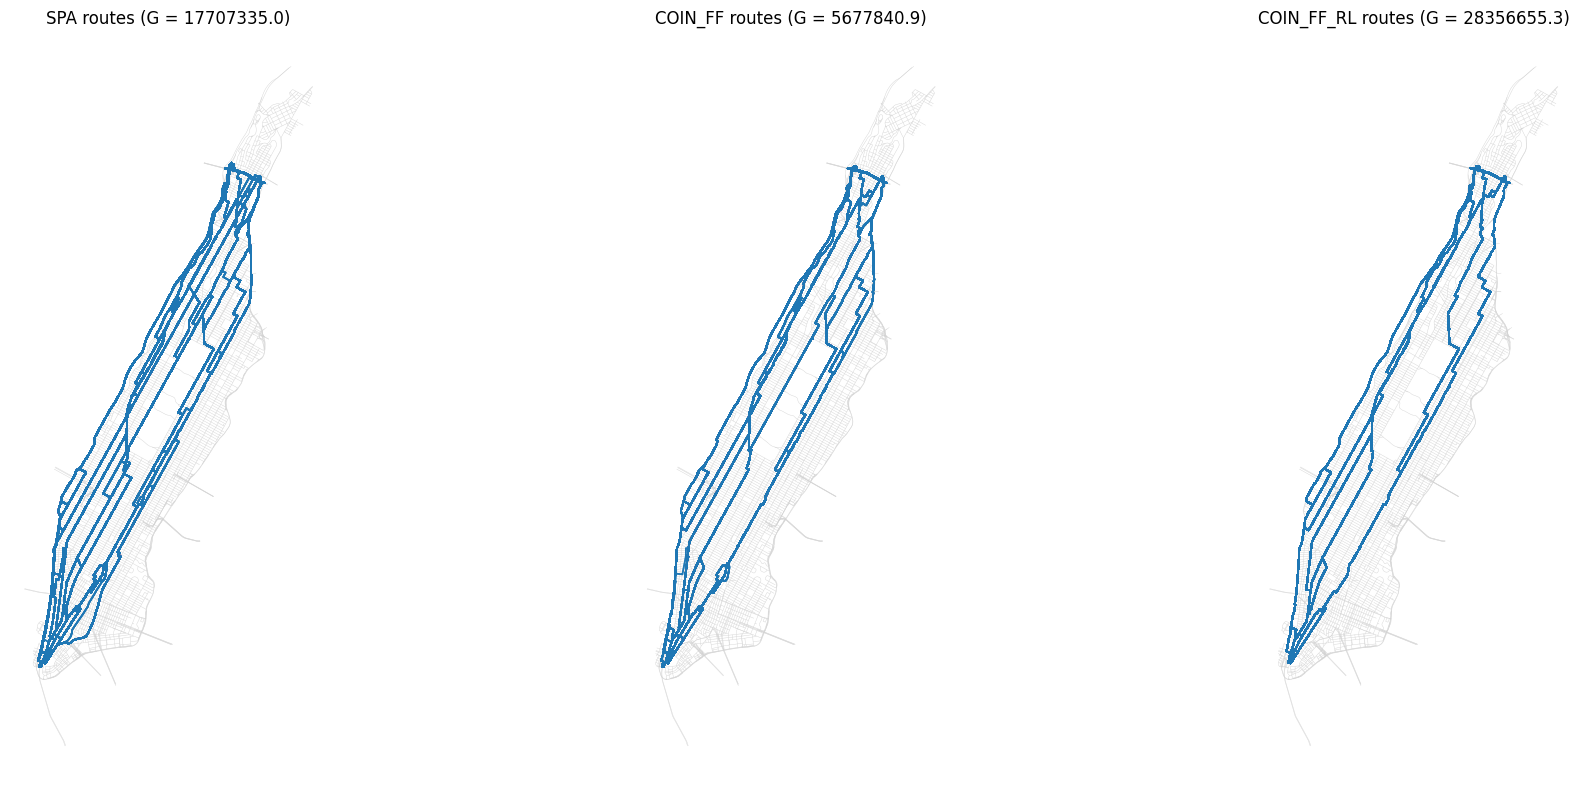

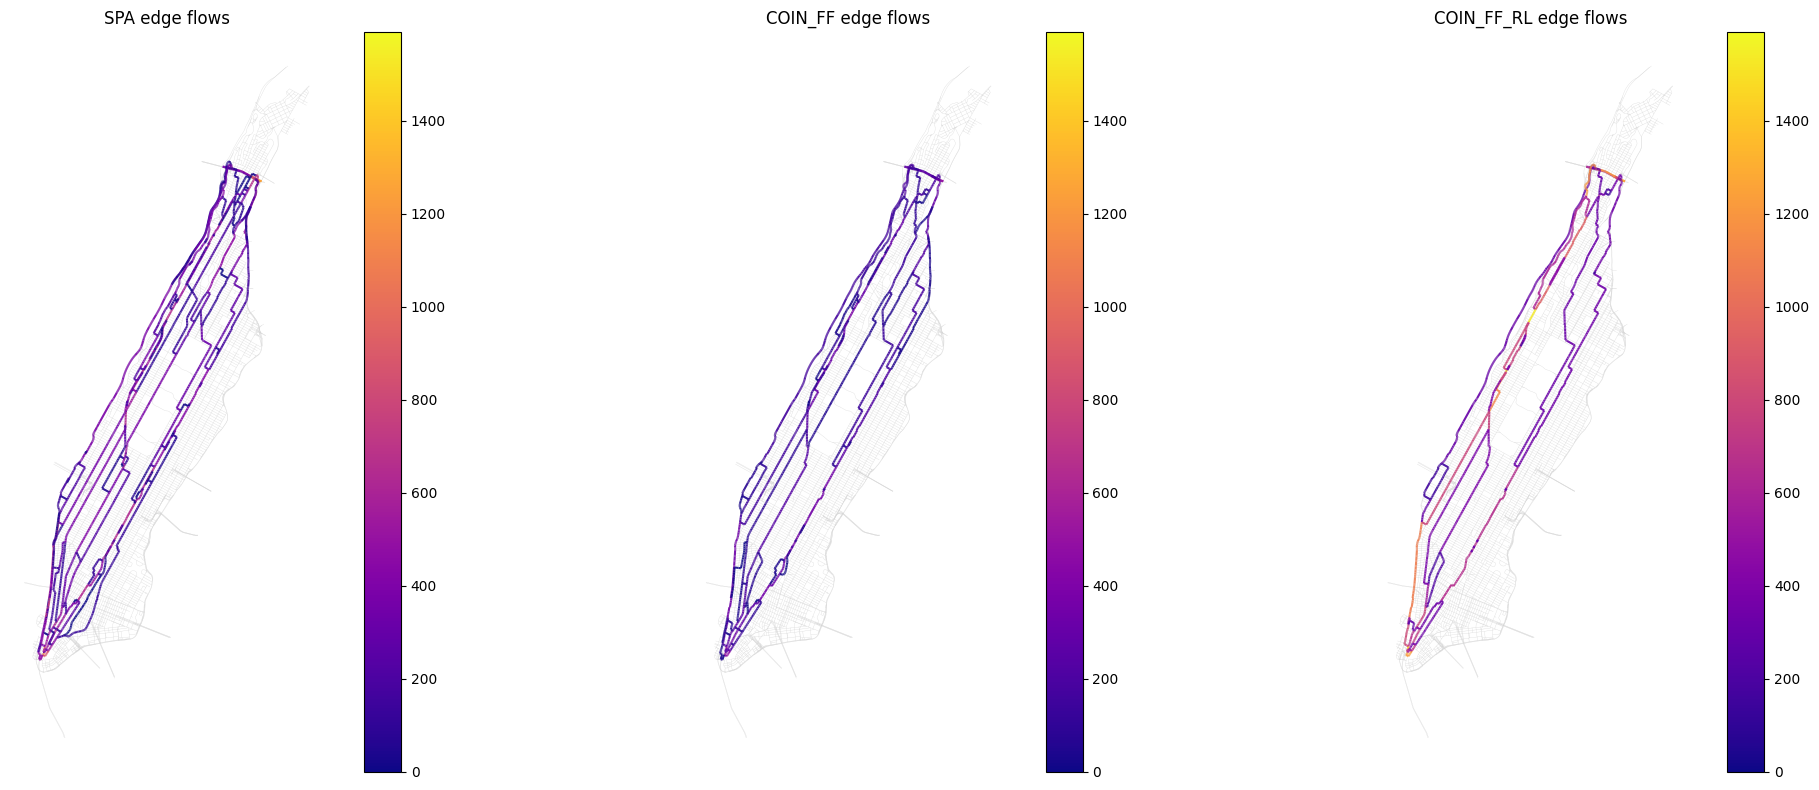

Saved 3-way route animation to manhattan_three_way_animation_2500.mp4 (80 frames, 20 fps)


In [39]:
random.seed(42)

# Number of agents:
num_agents = 2500

(
    agents_spa,
    flows_spa,
    G_spa,
    agents_coin_ff,
    flows_coin_ff,
    G_coin_ff,
    agents_coin_ff_rl,
    flows_coin_ff_rl,
    G_coin_ff_rl,
    Q_rl,
) = run_coin_ff_rl_from_expert_experiment(
    manhattan_network,
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents,
    num_agents_eval_rl=num_agents,
    od_mode="fixed",
)

# --- fractions reaching destination ---
print("\nSPA fraction reaching dest:", fraction_reached(agents_spa, destination))
print("COIN_FF fraction reaching dest:", fraction_reached(agents_coin_ff, destination))
print("COIN_FF_RL fraction reaching dest:", fraction_reached(agents_coin_ff_rl, destination))

# --- per-scenario metrics (avg time & distance) ---
print_scenario_metrics(
    "SPA",
    network=manhattan_network,
    flows=flows_spa,
    G=G_spa,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF",
    network=manhattan_network,
    flows=flows_coin_ff,
    G=G_coin_ff,
    num_agents=num_agents,
)

print_scenario_metrics(
    "COIN_FF_RL",
    network=manhattan_network,
    flows=flows_coin_ff_rl,
    G=G_coin_ff_rl,
    num_agents=num_agents,
)

# --- Route plots ---
# plot_routes_spa_vs_coin_ff(gdf, agents_spa, G_spa, agents_coin_ff, G_coin_ff)
# plot_routes_spa_vs_coin_ff_rl(gdf, agents_spa, G_spa, agents_coin_ff_rl, G_coin_ff_rl)
plot_routes_three_way(
    gdf,
    agents_spa,      G_spa,
    agents_coin_ff,  G_coin_ff,
    agents_coin_ff_rl, G_coin_ff_rl
)

# --- Heatmaps ---
# plot_heatmaps_spa_vs_coin_ff(gdf, manhattan_network, flows_spa, flows_coin_ff)
# plot_heatmaps_spa_vs_coin_ff_rl(gdf, manhattan_network, flows_spa, flows_coin_ff_rl)
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_coin_ff,
    flows_coin_ff_rl
)

animate_routes_three_way_light(
    gdf,
    agents_spa,
    agents_coin_ff,
    agents_coin_ff_rl,
    num_agents,
    out_path=f"manhattan_three_way_animation_{num_agents}.mp4",
    max_frames=80,
    fps=20,
    figsize=(9, 4),
    dpi=80,
)
